### Multidimensional Signal Processing: Analysis of Image and Audio Signals

Mikołaj Zuziak

Each student is assigned a unique variant of the task. For each variant, students must:
- Synthetically generate the specified grayscale image and audio signal.
- Perform multidimensional signal analysis including Fourier transform, filtering, and visualization.
- Compare time and frequency domain representations.

Important: The image and audio must be generated in Python using NumPy, OpenCV, or other standard libraries.

1. Load a grayscale image and compute its 2D Fourier Transform.
2. Visualize the magnitude spectrum of the image.
3. Apply a low-pass and high-pass filter in the frequency domain.
4. Reconstruct the image from the filtered spectrum.
5. Load an audio signal and compute its spectrogram.
6. Compare time-domain and frequency-domain representations.
7. Optional: Apply a denoising filter using frequency domain processing.


Variant 9:
- Image: Grid pattern with gaps (broken checkerboard).
- Audio: Sine wave with increasing amplitude over time (fade in)

In [39]:
import numpy as np
import cv2
from scipy.io.wavfile import write
import librosa
import librosa.display
from matplotlib import pyplot as plt

#### Generating Image: Grid with gaps

In [40]:
def generate_broken_grid(size=256, step=32):
    img = np.zeros((size, size), dtype=np.uint8)
    for i in range(0, size, step):
        if i % 64 != 0:
            img[i, :] = 255
            img[:, i] = 255
    cv2.imwrite('broken_grid.png', img)
    
generate_broken_grid()

#### Generating Audio: Fade-in sine

In [41]:
def generate_fadein_sine(fs=44100, duration=5, freq=440):
    t = np.linspace(0, duration, int(fs * duration))
    envelope = np.linspace(0, 1, len(t))
    y = envelope * np.sin(2 * np.pi * freq * t)
    write('fadein_sine.wav', fs, (y * 32767).astype(np.int16))
    
generate_fadein_sine()

#### Load image and audio

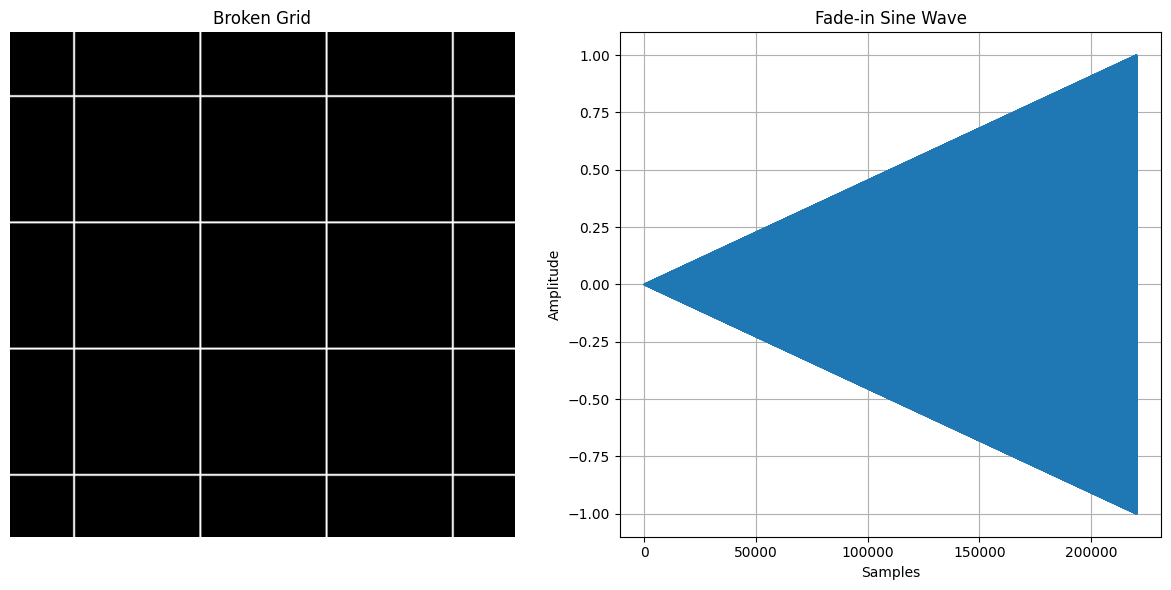

In [42]:
image = cv2.imread('./broken_grid.png', cv2.IMREAD_GRAYSCALE)
y, sr = librosa.load('./fadein_sine.wav', sr=None)

# Display the image and audio waveform
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Broken Grid')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.plot(y)
plt.title('Fade-in Sine Wave')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()

#### Image Analysis

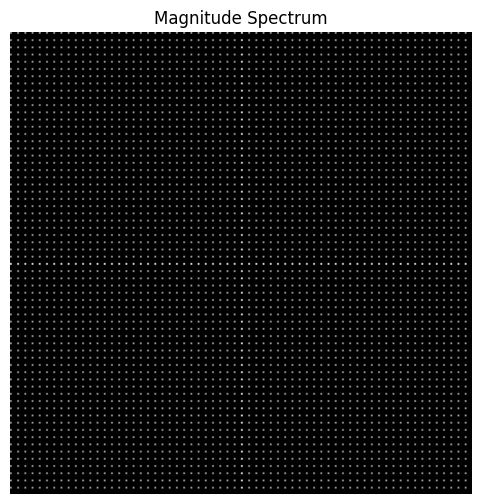

In [43]:
# Perform FFT on the image
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)  # Shift zero freq. to center

# Compute magnitude spectrum
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

plt.figure(figsize=(6,6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')
plt.show()

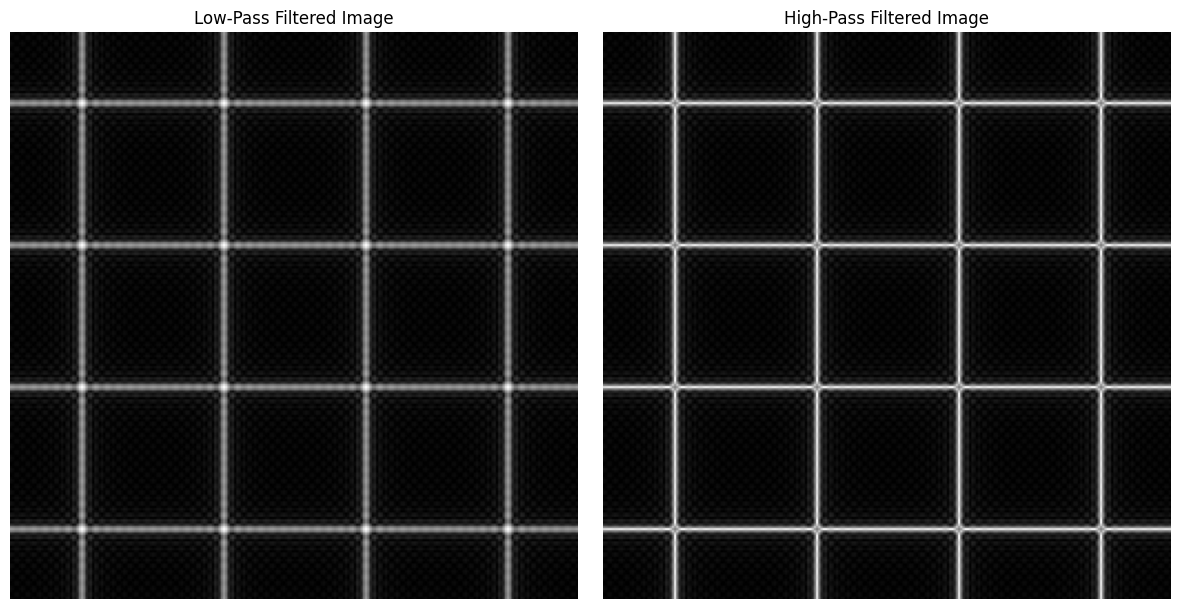

In [48]:
rows, cols = image.shape
crow, ccol = rows // 2 , cols // 2

# Create a low-pass filter mask (circle in the center)
mask_lp = np.zeros((rows, cols), np.uint8)
r = 50  # Radius
cv2.circle(mask_lp, (ccol, crow), r, 1, thickness=-1)

# Create high-pass mask as complement
mask_hp = 1 - mask_lp

# Apply the masks
fshift_lp = fshift * mask_lp
fshift_hp = fshift * mask_hp

# Inverse shift and IFFT for low-pass
f_ishift_lp = np.fft.ifftshift(fshift_lp)
img_back_lp = np.fft.ifft2(f_ishift_lp)
img_back_lp = np.abs(img_back_lp)

# Inverse shift and IFFT for high-pass
f_ishift_hp = np.fft.ifftshift(fshift_hp)
img_back_hp = np.fft.ifft2(f_ishift_hp)
img_back_hp = np.abs(img_back_hp)

# Display the result
plt.figure(figsize=(12, 6))

# Low-pass filtered image
plt.subplot(1, 2, 1)
plt.imshow(img_back_lp, cmap='gray')
plt.title('Low-Pass Filtered Image')
plt.axis('off')

# High-pass filtered image
plt.subplot(1, 2, 2)
plt.imshow(img_back_hp, cmap='gray')
plt.title('High-Pass Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()

The broken grid pattern in the spatial domain transforms into a distinct pattern in the frequency domain. The regular spacing of the grid lines creates specific frequency components visible as bright spots in the spectrum. These spots appear at:
- Horizontal lines: Represent vertical frequency components
- Vertical lines: Represent horizontal frequency components
- The pattern's symmetry in the frequency domain reflects the real nature of our input image

The low-pass filter preserves only the lowest frequencies (center of the spectrum), resulting in a blurred image that maintains the overall structure but loses the fine grid lines. The high-pass filter does the opposite - it enhances edges while removing the smooth areas.

#### Audio Analysis

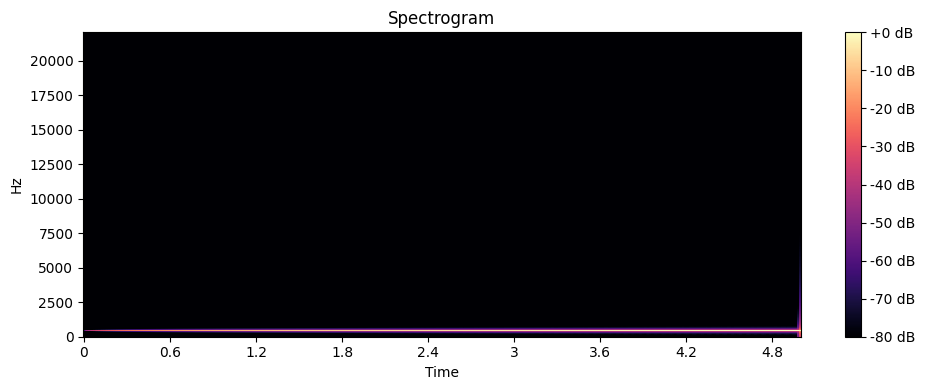

In [45]:
# Compute STFT
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Display spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

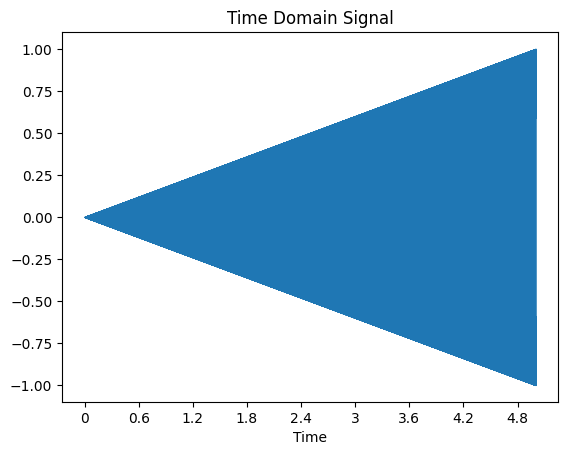

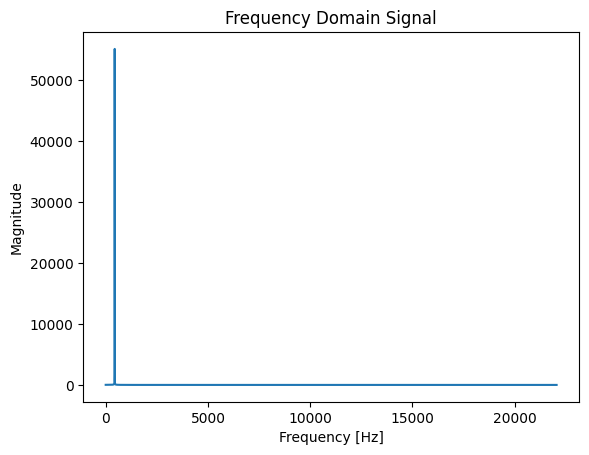

In [46]:
# Plot waveform (time domain)
plt.figure()
librosa.display.waveshow(y, sr=sr)
plt.title('Time Domain Signal')

# Plot magnitude spectrum (frequency domain)
Y = np.fft.fft(y)
freqs = np.fft.fftfreq(len(Y), 1/sr)
plt.figure()
plt.plot(freqs[:len(freqs)//2], np.abs(Y[:len(Y)//2]))
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

The fade-in sine wave shows:
- In the time domain: A gradually increasing amplitude with consistent oscillation frequency
- In the frequency domain: A dominant peak at 440Hz (our chosen frequency)
- The spectrogram shows how this single frequency remains constant over time while its amplitude increases

This demonstrates how time-varying characteristics (amplitude modulation) appear in different representations:
- Time domain clearly shows the amplitude envelope
- Frequency domain shows primarily the frequency content
- Spectrogram combines both, showing frequency content changing over time

#### Compare time-domain and frequency-domain representations

**Time Domain Signal**:
- Shows a triangular-shaped signal plotted over time (0 to about 5 seconds)
- The amplitude ranges from -1 to 1
- The signal appears to be linearly increasing in both the positive and negative directions from the origin, creating a triangular envelope

**Frequency Domain Signal**:
- Shows the frequency representation of the signal (from 0 to about 22,000 Hz)
- Has a very strong spike at 440 Hz
- The magnitude at this peak is approximately 55,000
- Beyond this initial spike, the frequency content rapidly drops to near zero across all higher frequencies

This pairing illustrates a fundamental principle in signal processing: a signal can be represented in either the time domain (showing how it varies over time) or the frequency domain (showing its frequency components).

This visualization demonstrates how signals that appear complex in one domain may have simple representations in the other domain, which is why domain transformations are so valuable in signal processing and analysis.

#### Optional: Apply a denoising filter using frequency domain processing.

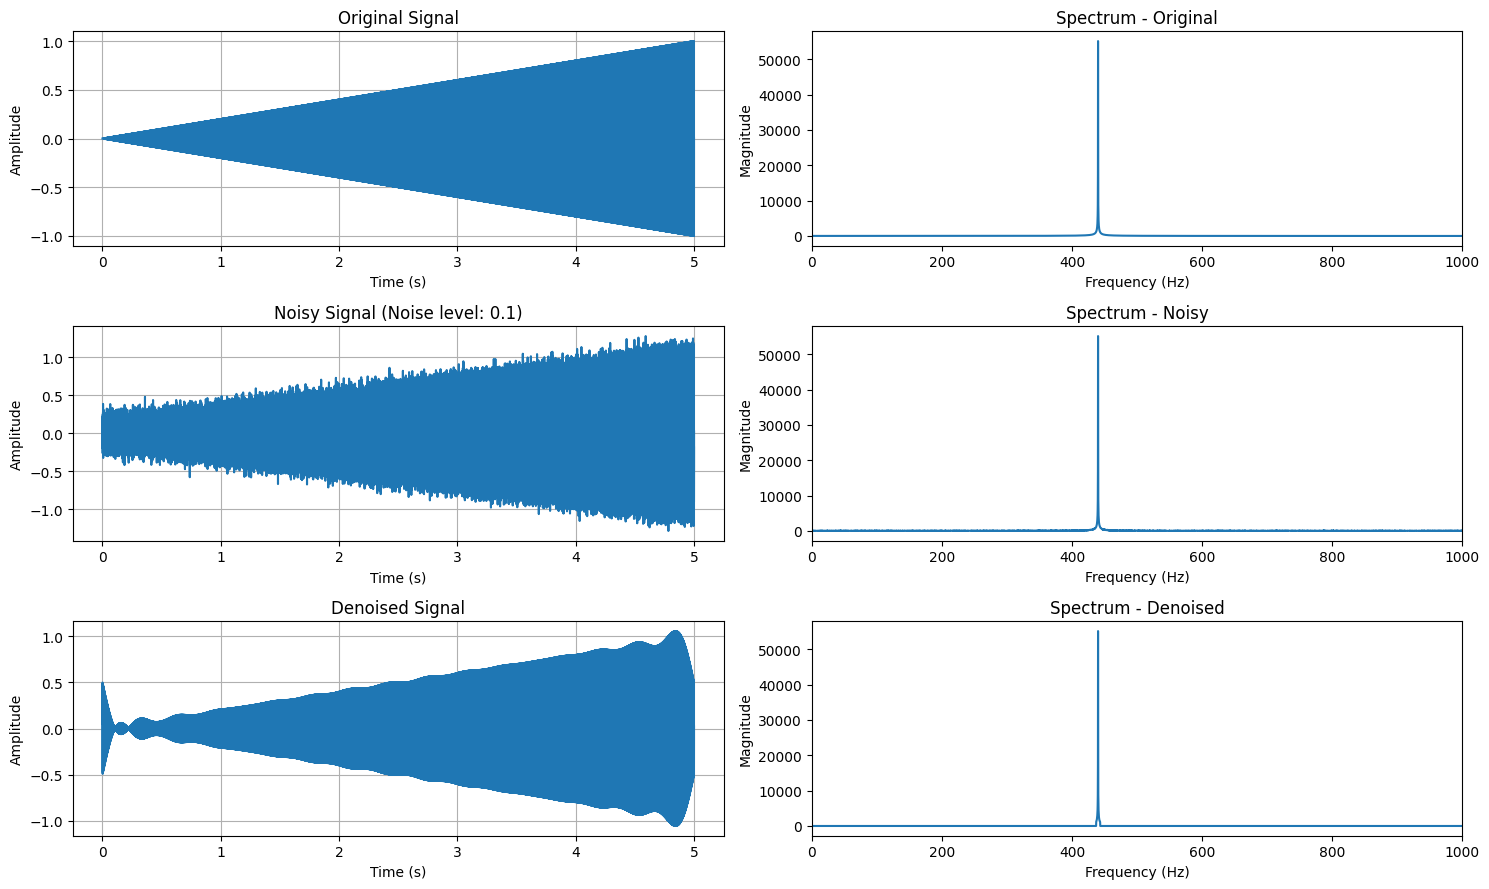

SNR before denoising: 12.22 dB
SNR after denoising: 20.06 dB
SNR improvement: 7.84 dB


In [ ]:
# A noisy version of the signal for demonstration
np.random.seed(42)  # For reproducibility
noise_level = 0.1
noisy_y = y + noise_level * np.random.randn(len(y))

# Compute FFT of noisy signal
Y_noisy = np.fft.fft(noisy_y)

# Simple threshold-based denoising in frequency domain
threshold = 0.02 * np.max(np.abs(Y_noisy))  # 2% of max as threshold
Y_denoised = Y_noisy.copy()
Y_denoised[np.abs(Y_noisy) < threshold] = 0

# Inverse FFT to get denoised signal
y_denoised = np.real(np.fft.ifft(Y_denoised))

# Plot original, noisy, and denoised signals for comparison
plt.figure(figsize=(15, 9))

# Original signal
plt.subplot(3, 2, 1)
plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

# Noisy signal
plt.subplot(3, 2, 3)
plt.plot(np.linspace(0, len(noisy_y)/sr, len(noisy_y)), noisy_y)
plt.title(f'Noisy Signal (Noise level: {noise_level})')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

# Denoised signal
plt.subplot(3, 2, 5)
plt.plot(np.linspace(0, len(y_denoised)/sr, len(y_denoised)), y_denoised)
plt.title('Denoised Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

# Frequency domain - original
plt.subplot(3, 2, 2)
Y_orig = np.fft.fft(y)
freqs_orig = np.fft.fftfreq(len(Y_orig), 1/sr)
plt.plot(freqs_orig[:len(freqs_orig)//2], np.abs(Y_orig[:len(Y_orig)//2]))
plt.title('Spectrum - Original')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 1000)

# Frequency domain - noisy
plt.subplot(3, 2, 4)
freqs_noisy = np.fft.fftfreq(len(Y_noisy), 1/sr)
plt.plot(freqs_noisy[:len(freqs_noisy)//2], np.abs(Y_noisy[:len(Y_noisy)//2]))
plt.title('Spectrum - Noisy')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 1000)

# Frequency domain - denoised
plt.subplot(3, 2, 6)
freqs_denoised = np.fft.fftfreq(len(Y_denoised), 1/sr)
plt.plot(freqs_denoised[:len(freqs_denoised)//2], np.abs(Y_denoised[:len(Y_denoised)//2]))
plt.title('Spectrum - Denoised')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 1000)

plt.tight_layout()
plt.show()

# Calculate denoising quality metrics
# https://en.wikipedia.org/wiki/Signal-to-noise_ratio
noise_snr = 10 * np.log10(np.sum(y**2) / np.sum((noisy_y - y)**2))
denoised_snr = 10 * np.log10(np.sum(y**2) / np.sum((y_denoised - y)**2))
print(f"SNR before denoising: {noise_snr:.2f} dB")
print(f"SNR after denoising: {denoised_snr:.2f} dB")
print(f"SNR improvement: {denoised_snr - noise_snr:.2f} dB")